In [1]:
%load_ext autoreload
%autoreload 2

# Compute geometric information

ggPIV and bbPIV are cell arrays of the first and second fundamental form evaluated at the PIV coordinate locations in a resized image (0.4 * original pixel dimensions) when compared to the embedding space of the embryo surface. The ith cell is the fundamental form of [X0(i), Y0(i)] evaluation point -- note that X0 and Y0 are unravelled for this indexing. \nX0 and Y0 are the resized image pixel positions of the PIV evaluation points. \ngg and bb are the first and second fundamental forms for each face of rect_embryo_noglue.ply compared to the pullback rect_PIVImageScale.ply
Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Metric at (0, 0)
 [[ 0.144  0.   ]
 [ 0.    30.005]]
Inverse metric at (0, 0)
 [[6.96  0.   ]
 [0.    0.033]]
Christoffel Symbol Shape:  (236, 200, 2, 2, 2)


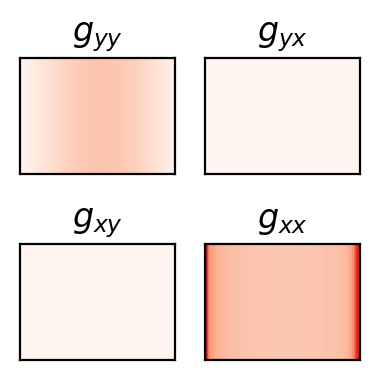

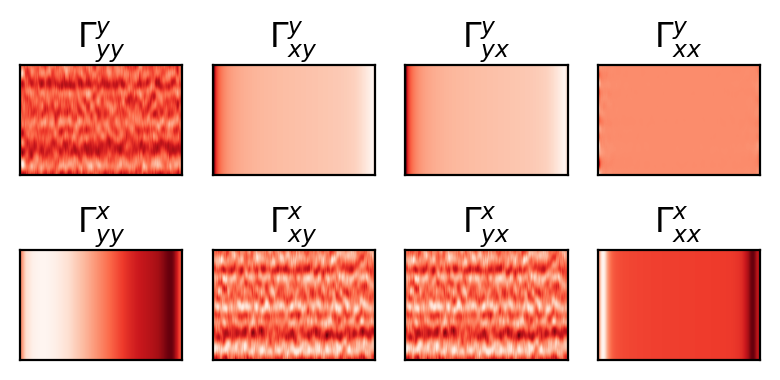

In [3]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import interpn, RectBivariateSpline
from scipy.io import loadmat
from utils.decomposition_utils import *

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *
from utils.plot_utils import *



with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)
    
diff_args = dict(
    dAP=dAP,
    dDV=dDV,
    sigma=5, 
)

def embryo_pad(x0, pad_width=20, dv_pad='wrap', ap_pad='edge', **kwargs):
    x = x0.reshape([-1, *x0.shape[-2:]])
    x = np.pad(x, ((0, 0), (pad_width, pad_width), (0, 0)), mode=dv_pad)
    x = np.pad(x,  ((0, 0), (0, 0), (pad_width, pad_width)), mode=ap_pad)
    x = x.reshape([*x0.shape[:-2], *x.shape[-2:]])
    '''
    Since we reflected along the x axis, we have to 
    adjust vector/tensor components in the reflected region
    '''
    if ap_pad in ['reflect', 'symmetric']:
        if len(x.shape) == 3: #Vector
            x[1, :,  :pad_width] *= -1
            x[1, :, -pad_width:] *= -1

        elif len(x.shape) == 4: #Tensor
            x[0, 1, :,  :pad_width] *= -1
            x[0, 1, :, -pad_width:] *= -1
            x[1, 0, :,  :pad_width] *= -1
            x[1, 0, :, -pad_width:] *= -1
    return x

def gradient(x0, dDV=2.7, dAP=2.7, sigma=5, **pad_kwargs):
    pad_width=4*sigma
    x = embryo_pad(x0, pad_width=pad_width, **pad_kwargs)

    dY_x = gaussian_filter1d(x, axis=-2, sigma=sigma, order=1, mode='nearest') / dDV
    dX_x = gaussian_filter1d(x, axis=-1, sigma=sigma, order=1, mode='nearest') / dAP
    return np.stack([
        dY_x[..., pad_width:-pad_width, pad_width:-pad_width],
        dX_x[..., pad_width:-pad_width, pad_width:-pad_width]
    ], axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
print(geometry['readme'])
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

#Interpolate metric onto evaluation points
gg = geometry['ggPIV']
gg = np.stack([g for g in gg], axis=0)
gg = np.stack([g for g in gg], axis=0).reshape([X0g.shape[0], Y0g.shape[0], 2, 2])
gg = gg.transpose(1, 0, 2, 3)
gg[..., 0, 1] = 0 #Eliminate off-diagonal metric components
gg[..., 1, 0] = 0 #Eliminate off-diagonal metric components
gg = np.broadcast_to(gg.mean(axis=0, keepdims=True), gg.shape) #Remove DV variation
gg = gg[..., ::-1, ::-1] #Swap y, x coordinates

gij = []
gg = gg.reshape([*gg.shape[:2], 4])
for i in range(gg.shape[-1]):
    gij.append(RectBivariateSpline(Y0g, X0g, gg[..., i])(dv, ap))
gij = np.stack(gij, axis=-1).reshape([dv.shape[0], ap.shape[0], 2, 2])
ginv = np.linalg.inv(gij)

#Print out metric information as a check
np.set_printoptions(precision=3, suppress=True)
print('Metric at (0, 0)\n', gij[0, 0])
print('Inverse metric at (0, 0)\n', ginv[0, 0])

#Build Christoffel symbols
gij_k = gradient(gij.transpose(2, 3, 0, 1), **diff_args)
gij_k = gij_k.transpose(2, 3, 0, 1, 4)

Gijk =  0.5 * (
    np.einsum('yxil,yxjlk->yxijk', ginv, gij_k) + \
    np.einsum('yxil,yxlkj->yxijk', ginv, gij_k) - \
    np.einsum('yxil,yxjkl->yxijk', ginv, gij_k)
)
print('Christoffel Symbol Shape: ', Gijk.shape)

fig, ax = plt.subplots(2, 2, dpi=200, figsize=(2, 2))
ij = ['y', 'x']
vmin = np.min(gij)
vmax = np.max(gij)
for i in range(2):
    for j in range(2):
        color_2D(ax[i, j], gij[..., i, j], cmap='Reds', vmin=vmin, vmax=vmax)
        ax[i, j].set_title('$g_{%s %s}$' % (ij[i], ij[j]))
        ax[i, j].set_aspect('auto')
plt.tight_layout()

fig, ax = plt.subplots(2, 4, dpi=200, figsize=(4, 2))
vmin = np.min(Gijk)
vmax = np.max(Gijk)
for i in range(2):
    for j in range(2):
        for k in range(2):
            color_2D(ax[i, 2*k+j], Gijk[..., i, j, k], cmap='Reds')#, vmin=vmin, vmax=vmax)
            ax[i, 2*k+j].set_title('$\\Gamma^{%s}_{%s %s}$' % (ij[i], ij[j], ij[k]))
            ax[i, 2*k+j].set_aspect('auto')
plt.tight_layout()

#np.save('Public/christoffel_symbols', Gijk)


def covariant_gradient(x0, **diff_args):
    grad_x = gradient(x0, **diff_args)

    if len(x0.shape) == 3: #Vector
        grad_x += np.einsum('yxijk,kyx->iyxj', Gijk, x0)
        #grad_x -= np.einsum('yxkij,kyx->iyxj', Gijk, x0)
    elif len(x0.shape) == 4: #Tensor
        grad_x += np.einsum('yxikl,ljyx->ijyxk', Gijk, x0) + \
                  np.einsum('yxjkl,ilyx->ijyxk', Gijk, x0)
        #grad_x -= np.einsum('yxlik,ljyx->ijyxk', Gijk, x0) + \
        #          np.einsum('yxljk,ilyx->ijyxk', Gijk, x0)
    return grad_x

# Pair rule gene alignment

In [21]:
from utils.dataset import *
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

transform = Compose([
    Reshape2DField(),
])

vel = AtlasDataset('WT', 'Runt', 'velocity2D', transform=Reshape2DField())
rnt = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
eve = AtlasDataset('WT', 'Even_Skipped-YFP', 'raw2D', transform=transform, drop_time=True)
ftz = AtlasDataset('WT', 'Fushi_Tarazu', 'raw2D', transform=transform)
slp = AtlasDataset('WT', 'Sloppy_Paired', 'raw2D', transform=transform)
prd = AtlasDataset('WT', 'Paired', 'raw2D', transform=transform)
trt = AtlasDataset('WT', 'Tartan', 'raw2D', transform=transform)


dataset = JointDataset([
    ('rnt', rnt),
    ('eve', eve),
    ('ftz', ftz),
    ('slp', slp),
    ('prd', prd),
    ('trt', trt),
    ('vel', vel),
], live_key='vel', ensemble=1)
dataset.df

100%|██████████| 1/1 [00:00<00:00, 585.14it/s]


,folder,tiff,embryoID,time,eIdx,key,dataset_idx,merged_index
0,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001150004,-19.000000,0,rnt,0,-1
1,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001150004,-18.000000,1,rnt,0,-1
2,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001150004,-17.000000,2,rnt,0,-1
3,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001150004,-16.000000,3,rnt,0,-1
4,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001150004,-15.000000,4,rnt,0,-1
...,...,...,...,...,...,...,...,...
1377,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,49.609360,17,vel,6,134
1378,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,51.183102,18,vel,6,135
1379,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,52.853797,19,vel,6,136
1380,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,202001141943,54.638666,20,vel,6,137


In [22]:
dataset.values.keys()

dict_keys([202001150004, 202001142033, 202001141730, 202001210044, 202001210000, 202001141943, 202001201216, 202001201716, -1])

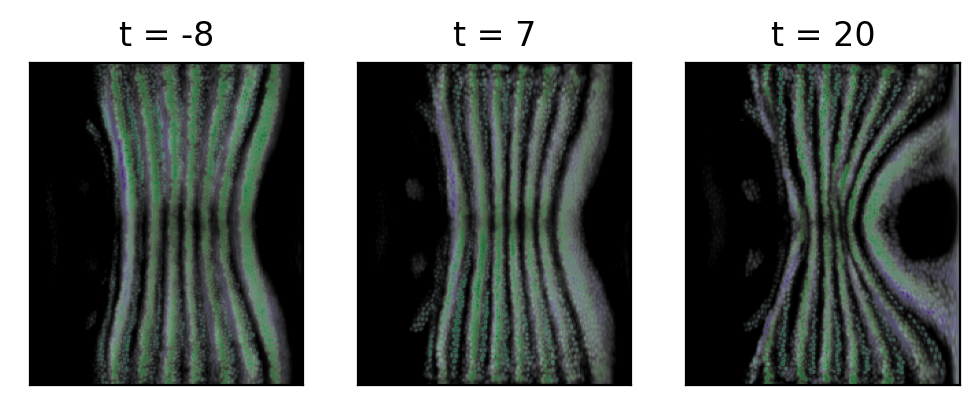

In [24]:
from utils.plot_utils import *
fig, ax = plt.subplots(1, 3, dpi=200)

colors = {
    'rnt': 'Purples',
    #'eve': 'Oranges',
    #'trt': 'Reds',
    'ftz': 'Greens',
    #'slp': 'Blues',
    'prd': 'BuGn',
}
for i, idx in enumerate([5, 20, 30]):
    batch = dataset[idx]
    for key in colors:
        field = batch[key][0] - np.median(batch[key][0])
        field[field < 0] = 0
        field /= np.ptp(field)
        ax[i].imshow(field, cmap=colors[key], alpha=field, extent=[ap_min, ap_max, dv_min, dv_max])
    ax[i].set_facecolor('black')
    ax[i].set(xticks=[], yticks=[])
    ax[i].set(xlim=[ap_min, ap_max], ylim=[dv_min, dv_max])
    ax[i].set(aspect='equal')
    ax[i].set_title('t = %d' % batch['time'])
    

In [28]:
%load_ext autoreload
%autoreload 2

from utils.dataset import *
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

transform = Compose([
    Reshape2DField(),
    ToTensor(),
])

vel = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform, tmin=-10, tmax=40)
rnt = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform, tmin=-10, tmax=40)
print(rnt.df.loc[rnt.df.embryoID == 202001210044, 'time'].values)
print(rnt.df.loc[vel.df.embryoID == 202001210044, 'time'].values)

dataset = TrajectoryDataset([
    ('rnt', rnt),
    ('vel', vel),
], live_key='vel')

loader = torch.utils.data.DataLoader(dataset, num_workers=2)
from tqdm import tqdm
for batch in tqdm(loader):
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 6/6 [00:00<00:00, 576.67it/s]


[-6.97598863 -5.98184142 -5.12009921 -4.17383763 -3.24406093 -2.32365025
 -1.40436704 -0.50285658  0.40967095  1.29308019  2.18897606  3.08051842
  3.99624993  4.9288938   5.91336789  6.97892234  8.15063068  9.46746694
 10.9292666  12.46870406 14.05105978 15.48244885 16.76066569 17.90306537
 18.94254957 19.89324707 20.7997394  21.72140055 22.57320456 23.49713311
 24.79276559 25.35315831 26.19706056 27.08038473 27.98229783 28.87278061
 29.70505592 30.45929449 31.26473627 31.96409464 32.72579254 33.39169607
 34.15360158 34.81798897 35.55553675 36.28139792 37.05166798 37.87484034
 38.73754045 39.62194069]
[-6.97598863 -5.98184142 -5.12009921 -4.17383763 -3.24406093 -2.32365025
 -1.40436704 -0.50285658  0.40967095  1.29308019  2.18897606  3.08051842
  3.99624993  4.9288938   5.91336789  6.97892234  8.15063068  9.46746694
 10.9292666  12.46870406 14.05105978 15.48244885 16.76066569 17.90306537
 18.94254957 19.89324707 20.7997394  21.72140055 22.57320456 23.49713311
 24.79276559 25.35315831 

100%|██████████| 217/217 [00:01<00:00, 137.11it/s]


In [19]:
dataset.df[dataset.df.embryoID == 202001210044].drop(['folder', 'tiff'], axis=1).tail(50)

,embryoID,time,eIdx,key,dataset_idx,merged_index,max_len,sequence_index
328,202001210044,-7,0,vel,1,171,49,161
329,202001210044,-6,1,vel,1,172,48,162
330,202001210044,-5,2,vel,1,173,47,163
331,202001210044,-4,3,vel,1,174,46,164
332,202001210044,-3,4,vel,1,175,45,165
333,202001210044,-2,5,vel,1,176,44,166
334,202001210044,-1,6,vel,1,177,43,167
335,202001210044,-1,7,vel,1,177,42,167
336,202001210044,0,8,vel,1,178,41,168
337,202001210044,1,9,vel,1,179,40,169


In [9]:
dataset.values[202001210044]['vel'].shape, dataset.values[202001210044]['rnt'].shape

((88, 2, 236, 200), (88, 236, 200))

# Curated myosin datasets

(57, 256, 218, 2, 2)
(79, 2, 2, 236, 200)
(57, 256, 218, 2, 2)
(75, 2, 2, 236, 200)


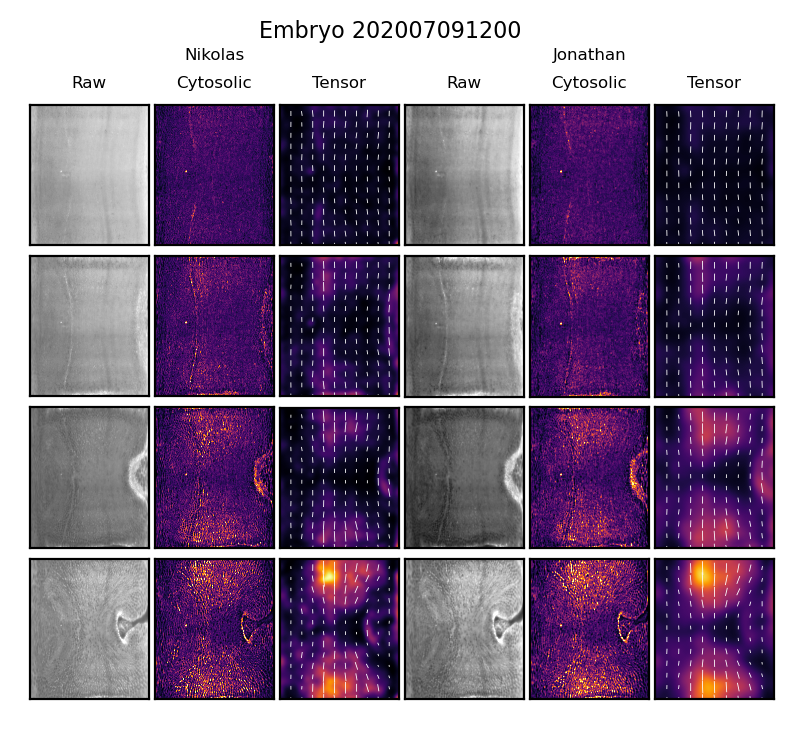

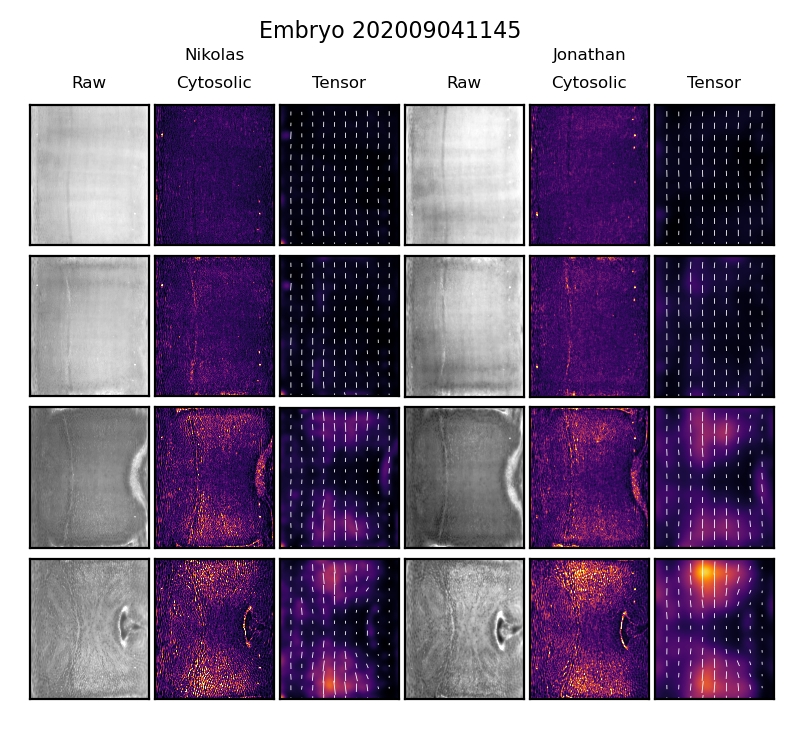

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob
from utils.plot_utils import *
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.titlesize'] = 8
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['figure.dpi'] = 200


nikolas_dir = '../nikolas_data/WT myosin datasets for Jonathan/'
jonathan_dir = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP'

eIds = ['202007091200', '202009041145']
offsets = [10, 0]

dt = 10
N = 4

for i, eId in enumerate(eIds):
    fig, ax = plt.subplots(N, 6, figsize=(6*0.8, N))

    raw_nik = Image.open(glob.glob(os.path.join(nikolas_dir, 'individual movies', eId+'_twistPlus_*.tif'))[0])
    cyt_nik = Image.open(os.path.join(nikolas_dir, 'individual movies', eId+'_cytosolic.tif'))
    ten_nik = np.load(os.path.join(nikolas_dir, 'individual movies', eId+ '_myosin.npy'), mmap_mode='r')
    
    raw_jon = np.load(os.path.join(jonathan_dir, eId, 'raw2D.npy'), mmap_mode='r')
    cyt_jon = np.load(os.path.join(jonathan_dir, eId, 'cyt2D.npy'), mmap_mode='r')
    ten_jon = np.load(os.path.join(jonathan_dir, eId, 'tensor2D.npy'), mmap_mode='r')
    
    cmin = np.median(cyt_jon) - np.std(cyt_jon)
    cmax = cmin + 5 * np.std(cyt_jon)
    
    dev = ten_jon - np.einsum('tkkyx,ij->tijyx', ten_jon, np.eye(2))
    mnorm = np.linalg.norm(dev, axis=(1, 2))
    mmin = np.min(mnorm)
    mmax = np.max(mnorm)
    
    offset = offsets[i]

    print(ten_nik.shape)
    print(ten_jon.shape)
    for i in range(N):
        raw_nik.seek(i*dt)
        raw = np.array(raw_nik)
        color_2D(ax[i, 0], raw, cmap='Greys_r', vmax_std=10)
        
        cyt_nik.seek(i*dt)
        cyt = np.array(cyt_nik)
        color_2D(ax[i, 1], cyt, vmax_std=1)
        
        tensor = ten_nik[dt*i].transpose(2, 3, 0, 1).copy()
        tensor = tensor[::-1, ::-1, :, :] #YX ordering
        tensor[0, 1] *= -1 #origin lower
        tensor[1, 0] *= -1 #origin lower
        plot_tensor2D(ax[i, 2], tensor)
        
        raw = raw_jon[i*dt+offset]
        color_2D(ax[i, 3], raw, cmap='Greys_r', vmax_std=10)
        
        cyt = cyt_jon[i*dt+offset]
        color_2D(ax[i, 4], cyt, vmin=cmin, vmax=cmax)

        tensor = ten_jon[i*dt+offset]
        plot_tensor2D(ax[i, 5], tensor, vmin=mmin, vmax=mmax)
        
        
    fig.text(0.5, 1.3, 'Nikolas', 
             fontsize=6,
             va='bottom', ha='center', 
             transform=ax[0, 1].transAxes)
    
    fig.text(0.5, 1.3, 'Jonathan', 
         fontsize=6,
         va='bottom', ha='center', 
         transform=ax[0, 4].transAxes)
        
    fig.suptitle('Embryo ' + eId)
    ax[0, 0].set_title('Raw')
    ax[0, 1].set_title('Cytosolic')
    ax[0, 2].set_title('Tensor')
    
    ax[0, 3].set_title('Raw')
    ax[0, 4].set_title('Cytosolic')
    ax[0, 5].set_title('Tensor')

    fig.subplots_adjust(hspace=0.01, wspace=0.05)


# Advected dorsal source

(36, 236, 200)


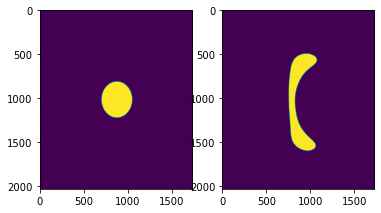

In [10]:
from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion

import numpy as np
import matplotlib.pyplot as plt

key='RECTANGLE'
key = 'ELLIPSE_A=0.5_B=0.25'
key = 'ELLIPSE_A=0.25_B=0.25'
key = 'CIRCLE_R=0.2'
base = 'dorsal_mask_%s_advected' % key
dorsal_mask = Image.open('Public/Masks/%s.tif' % base)

fig, ax = plt.subplots(1, 2)

mask = []
i = 0
while True:
    try:
        dorsal_mask.seek(i)
        mask.append(resize(np.array(dorsal_mask), (236, 200)))
        if i == 0:
            ax[0].imshow(dorsal_mask)
        i = i + 1
    except Exception as e:
        break

ax[1].imshow(dorsal_mask)
print(np.stack(mask).shape)
mask = np.stack(mask)
np.save('Public/Masks/%s_RESIZED.npy' % base, mask)

(36, 236, 200)


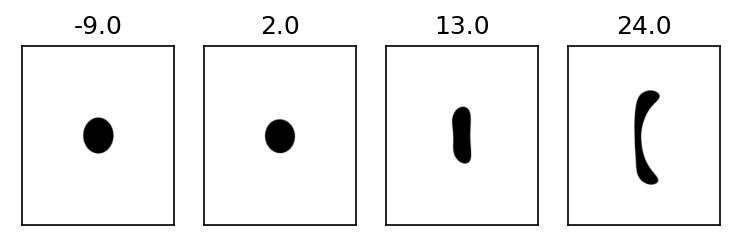

In [9]:
import numpy as np
import matplotlib.pyplot as plt
mask = np.load('Public/Masks/%s_RESIZED.npy' % base, mmap_mode='r')
time = np.load('Public/Masks/dorsal_mask_time.npy')
print(mask.shape)
fig, ax = plt.subplots(1, 4, dpi=150)
for i in range(4):
    ax[i].imshow(mask[i*11], cmap='Greys')
    ax[i].set(xticks=[], yticks=[], title=time[i*11])

# Posterior midgut + Cephallic furrow mask

attempt to seek outside sequence
(45, 236, 200)


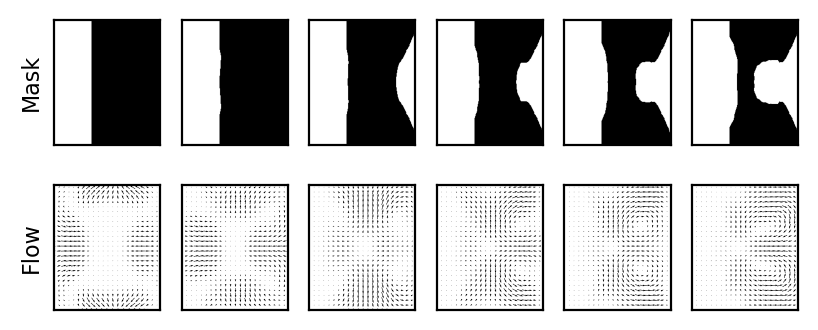

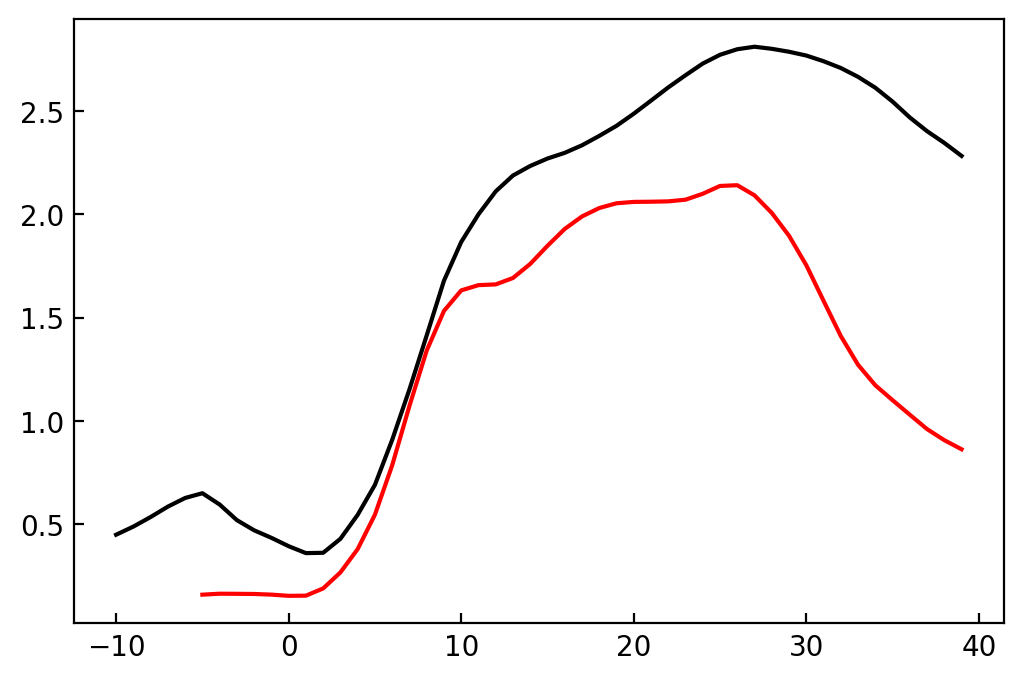

In [31]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'Greys'
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['figure.dpi'] = 200
plt.rcParams['image.origin'] = 'lower'

from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion
pmg_mask = Image.open('../nikolas_data/WT myosin datasets for Jonathan/ensemble/WT_PMG_mask.tif')
cf_mask = Image.open('../nikolas_data/WT myosin datasets for Jonathan/ensemble/WT_CF_mask.tif')
flow = np.load(os.path.join('../nikolas_data/WT myosin datasets for Jonathan/ensemble/WT_piv_ensemble.npy'), mmap_mode='r')

flow = flow.transpose(0, 3, 1, 2)
flow = flow[:, ::-1]
n = 3
i = 0
total_mask = []
while True:
    try:
        pmg_mask.seek(i)
        cf_mask.seek(i)
        mask = resize(np.array(pmg_mask), (236, 200)) + resize(np.array(cf_mask), (236, 200))
        mask = (mask + mask[::-1]) > 0
        total_mask.append(binary_dilation(mask, np.ones([n, n])))
        i += 1
    except Exception as e:
        print(e)
        break

total_mask = np.stack(total_mask)
total_mask = ~(np.cumsum(total_mask, axis=0) > 0)

print(total_mask.shape)
N = 6
fig, ax = plt.subplots(2, N, figsize=(N*0.8, 2))
d = 7
for i in range(N):
    im = ax[0, i].imshow(total_mask[i*d], vmin=0)
    plot_vector2D(ax[1, i], flow[i*d])

#plt.colorbar(im, ax=ax[0, -1])
for a in ax.flatten():
    a.set(xticks=[], yticks=[])
    a.set_aspect('equal')

ax[0, 0].set_ylabel('Mask')
ax[1, 0].set_ylabel('Flow')

fig, ax = plt.subplots(1, 1)
t = np.load('Public/WT/ECad-GFP/ensemble/t.npy')
v = np.load('Public/WT/ECad-GFP/ensemble/velocity2D.npy')
ax.plot(t, np.linalg.norm(v, axis=1).mean(axis=(1, 2)), color='black')

t = np.arange(flow.shape[0]) - 5
ax.plot(t, np.linalg.norm(flow, axis=1).mean(axis=(1, 2)), color='red')
    

np.save('Public/Masks/Dynamic_PMG_CF_mask', total_mask)
np.save('Public/Masks/Dynamic_PMG_CF_time', t)

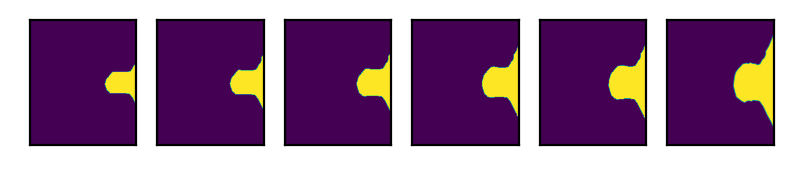

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['figure.dpi'] = 200

from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion
pmg_mask = np.array(Image.open('Public/Masks/MAX_WT_PMG_mask.tif'))
pmg_mask = resize(pmg_mask, (236, 200))

N = 6
fig, ax = plt.subplots(1, N, figsize=(N*0.8, 1))
d = 5
for i in range(N-1):
    n = (N-i) * d
    ax[i].imshow(binary_erosion(pmg_mask, np.ones([n, n])))
    
ax[-1].imshow(pmg_mask)
    
for a in ax.flatten():
    a.set(xticks=[], yticks=[])

(236, 200)


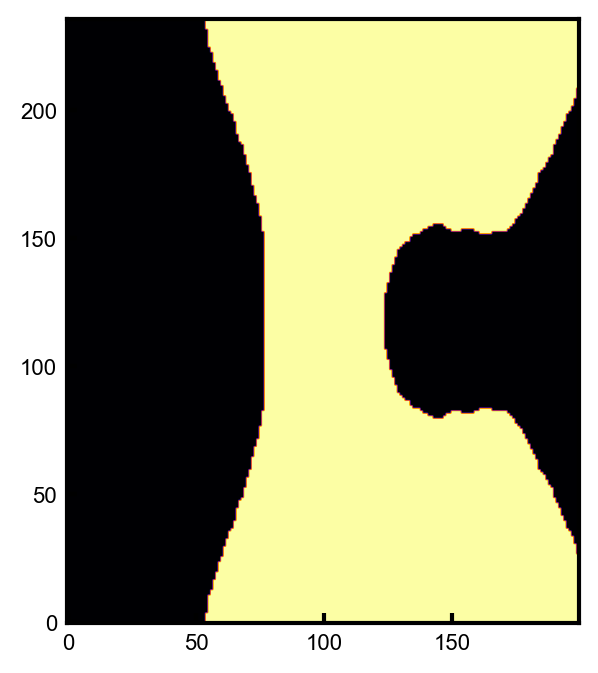

In [102]:
from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion
pmg_mask = np.array(Image.open('Public/MAX_WT_PMG_mask.tif'))
cf_mask = np.array(Image.open('Public/MAX_WT_CF_mask.tif'))

pmg_mask = np.array(pmg_mask)
cf_mask = np.array(cf_mask)
total_mask = resize(pmg_mask + cf_mask, (236, 200))
total_mask = (total_mask + total_mask[::-1]) > 0
n = 3
total_mask = ~binary_erosion(total_mask, np.ones([n, n]))
total_mask
print(total_mask.shape)
plt.imshow(total_mask)
np.save('Public/pmg_cf_mask', total_mask)

# Morphodynamic offsets

In [1]:
from utils.dataset import *
transform = Reshape2DField()
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True)

runt_dataset = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)
hist_dataset = AtlasDataset('WT', 'histone-RFP', 'velocity2D', transform=transform, drop_time=True)
eve_dataset = AtlasDataset('WT', 'Even_Skipped-YFP', 'velocity2D', transform=transform, drop_time=True)

100%|██████████| 3/3 [00:00<00:00, 13.44it/s]


In [14]:
offsets = pd.DataFrame(columns=['embryoID', 'offset']).set_index('embryoID')

offsets.loc[202006261115, 'offset'] = -1
offsets.loc[202007011145, 'offset'] = 21
offsets.loc[202007081130, 'offset'] = 13
offsets.loc[202007091200, 'offset'] = 21
offsets.loc[202008131005, 'offset'] = 10
offsets.loc[202009041145, 'offset'] = 11
offsets.to_csv('Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/morphodynamic_offsets.csv')
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True)

offsets = pd.DataFrame(columns=['embryoID', 'offset']).set_index('embryoID')
for eId in cad_dataset.df.embryoID.unique():
    offsets.loc[eId, 'offset'] = 18
offsets.to_csv('Public/WT/ECad-GFP/morphodynamic_offsets.csv')
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)


offsets = pd.DataFrame(columns=['embryoID', 'offset']).set_index('embryoID')
for eId in runt_dataset.df.embryoID.unique():
    offsets.loc[eId, 'offset'] = 20
offsets.loc[202001210044, 'offset'] -= 5
offsets.loc[202001141943, 'offset'] += 10
offsets.to_csv('Public/WT/Runt/morphodynamic_offsets.csv')
runt_dataset = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)

offsets = pd.DataFrame(columns=['embryoID', 'offset']).set_index('embryoID')
offsets.loc[202001201216, 'offset'] = 0
offsets.loc[202001201716, 'offset'] = 23
offsets.to_csv('Public/WT/Even_Skipped-YFP/morphodynamic_offsets.csv')
eve_dataset = AtlasDataset('WT', 'Even_Skipped-YFP', 'velocity2D', transform=transform, drop_time=True)

offsets = pd.DataFrame(columns=['embryoID', 'offset']).set_index('embryoID')
for eId in hist_dataset.df.embryoID.unique():
    offsets.loc[eId, 'offset'] = 23
offsets.loc[20140612184500, 'offset'] -= 7
offsets.loc[20140912174700, 'offset'] += 2
offsets.loc[20140916131600, 'offset'] += 9
offsets.loc[20140917212700, 'offset'] += 14
offsets.to_csv('Public/WT/histone-RFP/morphodynamic_offsets.csv')
hist_dataset = AtlasDataset('WT', 'histone-RFP', 'velocity2D', transform=transform, drop_time=True)

100%|██████████| 5/5 [00:00<00:00, 628.60it/s]


Sqh-GFP
ECad-GFP
Runt
Even_Skipped-YFP
histone-RFP


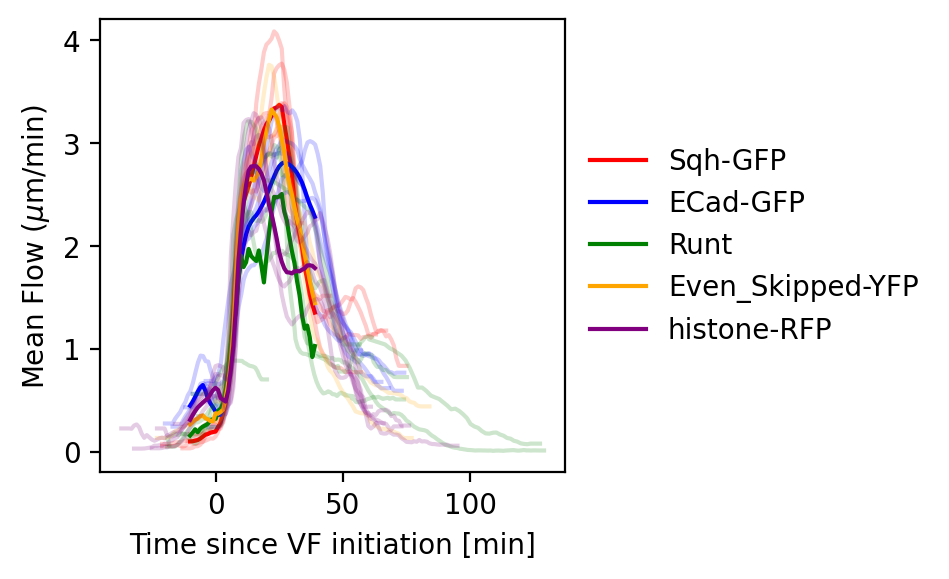

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(3, 3))
ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax.set_ylim([-0.2, 4.2])
ax.set_xlabel('Time since VF initiation [min]')

for dataset, color in zip([sqh_dataset, cad_dataset, runt_dataset, eve_dataset, hist_dataset], 
                          ['red', 'blue', 'green', 'orange', 'purple']):
    for eId in dataset.df.embryoID.unique():
        values = dataset.values[eId]
        time = dataset.df.loc[dataset.df.embryoID == eId, 'time']
        norm = np.linalg.norm(values.reshape([values.shape[0], -1, *values.shape[-2:]]), axis=1).mean(axis=(1, 2))
        if 'Runt' in dataset.label or 'Eve' in dataset.label:
            norm /= 0.2619 / 0.4
        if 'hist' in dataset.label:
            norm *= 0.2619 / 0.4
        ax.plot(time, norm, color=color, alpha=0.2)

    label = '_'.join(os.path.basename(dataset.label).split('_')[:-1])
    print(label)
    ensemble_v = np.load(os.path.join(dataset.path, 'ensemble', 'velocity2D.npy'))
    norm = np.linalg.norm(ensemble_v, axis=(1)).mean(axis=(1, 2))
    ensemble_t = np.load(os.path.join(dataset.path, 'ensemble', 't.npy'))
    if 'Runt' in dataset.label or 'Eve' in dataset.label:
        norm /= 0.2619 / 0.4
    if 'hist' in dataset.label:
        norm *= 0.2619 / 0.4    
    ax.plot(ensemble_t, norm, color=color, label=label)

ax.legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0)

#ax.set_xlim([-10, 40])
        
fig.subplots_adjust(hspace=0)

# Create SVD models

In [2]:
from utils.dataset import *
from torchvision.transforms import Compose
from atlas_processing.anisotropy_detection import cell_size
transform = Reshape2DField()
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'raw2D', transform=Compose([transform, Smooth2D(sigma=7)]), tmin=-15, tmax=45)
cad_vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform, tmin=-15, tmax=45)

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True, tmin=-15, tmax=45)
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True, tmin=-15, tmax=45)

runt_dataset = AtlasDataset('WT', 'Runt', 'raw2D', transform=Compose([transform, Smooth2D(sigma=1)]))
hist_dataset = AtlasDataset('WT', 'histone-RFP', 'raw2D', transform=Compose([transform, Smooth2D(sigma=0.5)]), drop_time=True,)
eve_dataset = AtlasDataset('WT', 'Even_Skipped', 'raw2D', transform=Compose([transform, Smooth2D(sigma=1)]), drop_time=True)

/project/vitelli/jonathan/REDO_fruitfly/src/atlas_processing/windowed_radon.py:300: RuntimeWarning: divide by zero encountered in true_divide
  line_weights = 1/(2*np.sqrt(e_len**2-(delta)**2))
100%|██████████| 1/1 [00:00<00:00, 575.75it/s]


In [6]:
from utils.decomposition.decomposition_utils import get_decomposition_results

pmg_cf_mask = np.load('Public/Masks/pmg_cf_mask.npy')

sqh_info = get_decomposition_results(sqh_dataset, overwrite=True, crop=10, model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
sqh_info = get_decomposition_results(sqh_dataset, overwrite=True, crop=10)

cad_info = get_decomposition_results(cad_dataset, overwrite=True, crop=10, model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
cad_info = get_decomposition_results(cad_dataset, overwrite=True, crop=10)

cad_vel_info = get_decomposition_results(cad_vel_dataset, overwrite=True, crop=10)
sqh_vel_info = get_decomposition_results(sqh_vel_dataset, overwrite=True, crop=10)

#runt_info = get_decomposition_results(runt_dataset, overwrite=True, crop=10, model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
#runt_info = get_decomposition_results(runt_dataset, overwrite=True, crop=10)

Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/decomposition_models/tensor_SVDPipeline_PMG_CF
Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/decomposition_models/tensor_SVDPipeline
Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/WT/ECad-GFP/decomposition_models/raw_SVDPipeline_PMG_CF
Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/WT/ECad-GFP/decomposition_models/raw_SVDPipeline
Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/WT/ECad-GFP/decomposition_models/velocity_SVDPipeline
Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/decomposition_models/velocity_SVDPipeline


In [4]:
from utils.decomposition.decomposition_utils import get_decomposition_results
runt_info = get_decomposition_results(runt_dataset, overwrite=True, crop=10, lrsym=False)
hist_info = get_decomposition_results(hist_dataset, n_components=32, overwrite=True, crop=10, lrsym=False)
eve_info = get_decomposition_results(eve_dataset, overwrite=True, crop=10, lrsym=False)

Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/WT/Runt/decomposition_models/raw_SVDPipeline
Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/WT/histone-RFP/decomposition_models/raw_SVDPipeline
Building new SVDPipeline for this dataset
/project/vitelli/jonathan/REDO_fruitfly/src/Public/WT/Even_Skipped/decomposition_models/raw_SVDPipeline


# Visualize library terms

0.11047058298810093 0.2838379731556893
(50, 2, 2, 236, 200) (50, 2, 236, 200) (50, 2, 2, 236, 200)


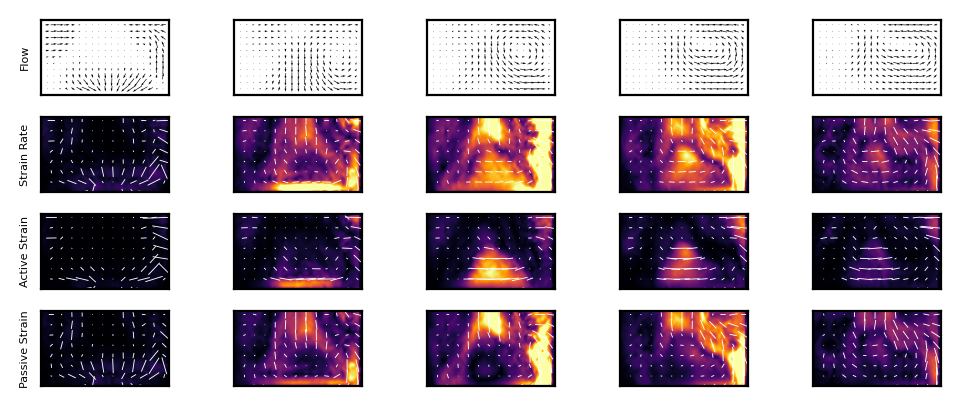

In [13]:
from math import ceil
from utils.plot_utils import *
import pickle as pk
import h5py

traj = 0
tts = [0, 10, 20, 30, 40]
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

fig, ax = plt.subplots(4, len(tts), dpi=200, figsize=(len(tts), 2))

with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    lib = h5f['ensemble']
    fields = lib['fields']
    
    m = fields['m_ij'][()]
    mnorm = np.linalg.norm(m, axis=(1, 2))
    mmin = mnorm.mean()
    mmax = mnorm.max()
    
    print(mmin, mmax)

    v = fields['v'][()]
    
    E = lib['links']['v']['tensor_library']['E'][()]
    
    E_mag = np.linalg.norm(E, axis=(1, 2))
    emin = E_mag.min()
    emax = emin + 3 * E_mag.std()
    
    print(E.shape, v.shape, m.shape)
        
    deviatoric = m - 0.5 * np.einsum('bkkyx,ij->bijyx', m, np.eye(2))
    
    m0 = np.linalg.norm(m, axis=(1, 2), keepdims=True).mean(axis=(3, 4), keepdims=True)
    dev_mag = np.linalg.norm(deviatoric, axis=(1, 2), keepdims=True)
        
    devE = np.einsum('bklyx,bklyx->byx', deviatoric, E)[:, None, None]
    
    E_active = E - np.sign(devE) * devE * deviatoric / dev_mag**2
    E_active = 0.5 * E_active * dev_mag / m0
    
    E_passive = E - E_active
    
    E_a_mag = np.linalg.norm(E_active, axis=(1, 2))
    
    E_proj_a = np.einsum('bklyx,bklyx->byx', E_active, E)[:, None, None] * E_active / E_a_mag[:, None, None]**2
    E_proj_a_mag = np.linalg.norm(E_proj_a, axis=(1, 2))
    
    kwargs = dict(vmin=mmin, vmax=mmax, skip=skip)
    ewargs = dict(vmin=emin, vmax=emax, skip=skip)
    
    for i, tt in enumerate(tts):
        ti = np.argmin(np.abs(fields['m_ij'].attrs['t'] - tt))
        plot_vector2D(ax[0, i], v[ti])
        plot_tensor2D(ax[1, i], E[ti], **ewargs)
        plot_tensor2D(ax[2, i], E_active[ti], **ewargs)
        plot_tensor2D(ax[3, i], E_passive[ti], **ewargs)

        
    ax[0, 0].set_ylabel('Flow')
    ax[1, 0].set_ylabel('Strain Rate')
    ax[2, 0].set_ylabel('Active Strain')
    ax[3, 0].set_ylabel('Passive Strain')    
    
    plt.tight_layout()

{'m_ij': 0.11047058298810093, 'v': 1.7675705014043808, 'c': 1.0744825701781937}


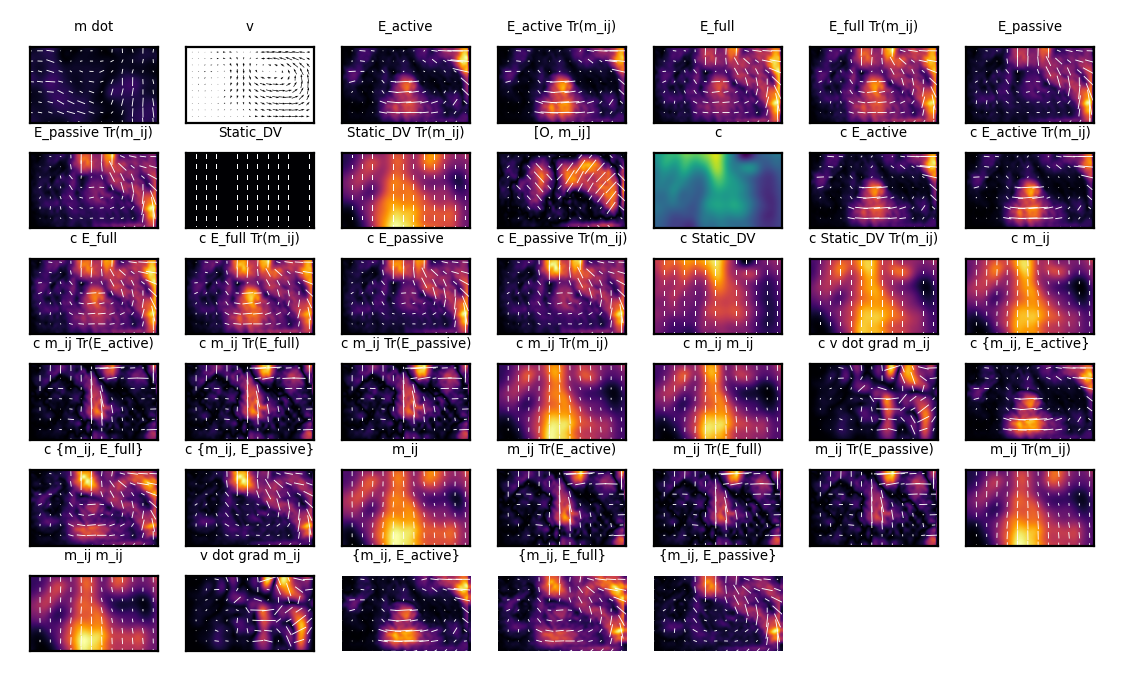

In [27]:
from math import ceil
from utils.plot_utils import *

traj = 0
tt = 35
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    fields = lib['fields']
    ti = np.argmin(np.abs(fields['m_ij'].attrs['t'] - tt))
    
    means = {
        'm_ij': np.linalg.norm(fields['m_ij'], axis=(1, 2)).mean(),
        'v': np.linalg.norm(fields['v'], axis=1).mean(),
        'c': np.mean(fields['c'])
    }
    print(means)
    keys = list(lib['X_raw'].keys()) #+ list(lib['U_raw'].keys())
    n_plots = 2 + len(keys)

    n_cols = 7
    n_rows = ceil(n_plots / n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, 
                       figsize=(n_cols, n_rows/1.5),
                       sharey=True, sharex=True, dpi=200)

    m_dot = lib['X_dot/m_ij'][..., 0][ti]
    m = fields['m_ij']
    mnorm = np.linalg.norm(m, axis=(1, 2))
    vmin = mnorm.min()
    vmax = mnorm.max()
    
    ax = ax.flatten()
    ax[0].set_title('m dot')
    plot_tensor2D(ax[0], m_dot, vmin=0, vmax=np.std(mnorm), skip=skip)
    
    ax[1].set_title('v')
    plot_vector2D(ax[1], lib['fields/v'][ti])
    
    raw = lib['X_raw']
    for i, key in enumerate(keys):
        feat = lib['X_raw'][key][ti]
        
        if lib['X_raw'][key].attrs['space'] > 0:
            kwargs = dict(vmin=0, vmax=np.std(mnorm))
        else:
            kwargs = dict(vmin=vmin, vmax=vmax)
        
        if len(lib['X_raw'][key].shape) == 3:            
            color_2D(ax[i+2], feat, cmap='viridis')
        else:
            fnorm = np.linalg.norm(feat, axis=(0, 1))
            plot_tensor2D(ax[i+2], feat[()], skip=skip, linewidth=0.007)
        ax[i+2].set_title(key)

    for j in range(i, len(ax)):
        ax[j].axis('off')
        
    fig.subplots_adjust(hspace=0.4, wspace=0.05)

In [13]:
%load_ext autoreload
%autoreload 2
from utils.decomposition.decomposition_model import SVDPipeline
from utils.library.derivative_library_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
